In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_root = './Data/'

## Explainable Boosting Classifier

+ https://github.com/interpretml/interpret

In [3]:
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
from interpret import show

### Heart Disease

In [4]:
df = pd.read_csv(f'{data_root}heart.csv')

train_cols = df.columns[0:-1]
label = df.columns[-1]
X_df = df[train_cols]
y_df = df[label]

In [5]:
ebm = ExplainableBoostingClassifier(n_jobs=-1, interactions=0)
ebm.fit(X_df, y_df)

ExplainableBoostingClassifier(feature_names=['age', 'sex', 'cp', 'trestbps',
                                             'chol', 'fbs', 'restecg',
                                             'thalach', 'exang', 'oldpeak',
                                             'slope', 'ca', 'thal'],
                              feature_types=['continuous', 'categorical',
                                             'continuous', 'continuous',
                                             'continuous', 'categorical',
                                             'continuous', 'continuous',
                                             'categorical', 'continuous',
                                             'continuous', 'continuous',
                                             'categorical'],
                              interactions=0, n_jobs=-1)

In [6]:
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2162433095760/ -->

As is depicted in the above plots, we can get the following table.

| Variable | Montonicity |
| --- | --- |
| age | increasing |
| thalach | decreasing |
| oldpeak | increasing |

### Census Income

In [7]:
df = pd.read_csv(f'{data_root}adult.data', header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
train_cols = df.columns[0:-1]
label = df.columns[-1]
X_df = df[train_cols]
y_df = df[label]

In [8]:
ebm = ExplainableBoostingClassifier(n_jobs=-1, interactions=0)
ebm.fit(X_df, y_df)

ExplainableBoostingClassifier(feature_names=['Age', 'WorkClass', 'fnlwgt',
                                             'Education', 'EducationNum',
                                             'MaritalStatus', 'Occupation',
                                             'Relationship', 'Race', 'Gender',
                                             'CapitalGain', 'CapitalLoss',
                                             'HoursPerWeek', 'NativeCountry'],
                              feature_types=['continuous', 'categorical',
                                             'continuous', 'categorical',
                                             'continuous', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'continuous', 'continuous',
                                             'continuous', 'categorical'],
                      

In [9]:
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2162466672352/ -->

As is depicted in the above plots, we can get the following table.

| Variable | Montonicity |
| --- | --- |
| EducantionNum | increasing |
| CapitalGain | increasing |

### Edmonton House Price

In [10]:
df = pd.read_csv(f'{data_root}housing_train.csv')
df.dropna(inplace=True)
train_cols = [
    'Latitude', 'Longitude', 'Neighbourhood',
    'Actual Year Built', 'Garage', 'Zoning', 'Lot Size'
]
label = 'Assessed_value_log'
X_df = df[train_cols]
y_df = df[label]

In [11]:
ebm = ExplainableBoostingRegressor(n_jobs=-1, interactions=0)
ebm.fit(X_df, y_df)

ExplainableBoostingRegressor(feature_names=['Latitude', 'Longitude',
                                            'Neighbourhood',
                                            'Actual Year Built', 'Garage',
                                            'Zoning', 'Lot Size'],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'categorical', 'continuous',
                                            'continuous'],
                             interactions=0, n_jobs=-1)

In [12]:
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2162341143792/ -->

As is depicted in the above plots, we can get the following table.

| Variable | Montonicity |
| --- | --- |
| Latitude | decreasing |
| Longitude | decreasing |
| Actual Year Built | increasing |
| Lot Size | increasing |

## Spearman correlation

In [13]:
from scipy.stats import spearmanr

In [14]:
import itertools

t1 = ('heart', 'adult', 'housing')
t2 = ('Spearman_rank', 'Mann_Kendall')

output_tables = dict()
for pair in itertools.product(t1, t2):
    output_tables[pair] = None

output_tables

{('heart', 'Spearman_rank'): None,
 ('heart', 'Mann_Kendall'): None,
 ('adult', 'Spearman_rank'): None,
 ('adult', 'Mann_Kendall'): None,
 ('housing', 'Spearman_rank'): None,
 ('housing', 'Mann_Kendall'): None}

### Heart Disease

In [15]:
df = pd.read_csv(f'{data_root}heart.csv')
df.dropna(inplace=True)
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0


In [16]:
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target_var = 'target'

In [17]:
corr_list = []
p_value_list = []
relationship_list = []

for col in num_cols:
    if df[col].nunique() > 150:
        df[col] = pd.qcut(df[col], 100, labels=False, duplicates='drop')
        df[col] = df[col].astype(np.float32)
    
    t = df[[col,target_var]].groupby(col).mean().reset_index()

    corr, p_value = spearmanr(t[col].values, t[target_var].values)
    
    corr_list.append(f'{corr:.03f}')
    p_value_list.append(f'{p_value:.03}')
    
    if p_value < 0.05 and abs(corr) > 0.5:
        relationship = 'Increasing' if corr > 0 else 'Decreasing'
    else:
        relationship = 'p_value > 0.05 or abs(corr) < 0.5'
        
    relationship_list.append(relationship)


In [18]:
summary_df = pd.DataFrame({'Input Columns':num_cols, 'Correlation':corr_list, 'p_value':p_value_list, 'Relationship':relationship_list})
summary_df['Target'] = target_var
summary_df = summary_df[['Input Columns', 'Target', 'Correlation', 'p_value', 'Relationship']].copy()
summary_df

,Input Columns,Target,Correlation,p_value,Relationship
0,age,target,0.384,0.0131,p_value > 0.05 or abs(corr) < 0.5
1,trestbps,target,0.188,0.191,p_value > 0.05 or abs(corr) < 0.5
2,chol,target,0.143,0.166,p_value > 0.05 or abs(corr) < 0.5
3,thalach,target,-0.588,9.01e-10,Decreasing
4,oldpeak,target,0.635,1.08e-05,Increasing


In [19]:
output_tables[('heart', 'Spearman_rank')] = {'Feature': num_cols, 'Correlation': corr_list, 'p_value': p_value_list, 'Relationship': relationship_list}

### Census Income

In [20]:
df = pd.read_csv(f'{data_root}adult.data', header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
train_cols = df.columns[0:-1]
label = df.columns[-1]
df.dropna(inplace=True)
df['target'] = df[label].astype('category')
df['target'] = df['target'].cat.codes
df.head(3)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0


In [21]:
num_cols = [
    'Age', 'fnlwgt', 'EducationNum', 
    'CapitalGain', 'CapitalLoss', 'HoursPerWeek'
]
target_var = 'target'

In [22]:
corr_list = []
p_value_list = []
relationship_list = []

for col in num_cols:
    if df[col].nunique() > 150:
        df[col] = pd.qcut(df[col], 100, labels=False, duplicates='drop')
        df[col] = df[col].astype(np.float32)

    t = df[[col,target_var]].groupby(col).mean().reset_index()

    corr, p_value = spearmanr(t[col].values, t[target_var].values)
    
    corr_list.append(f'{corr:.03f}')
    p_value_list.append(f'{p_value:.03}')
    
    if p_value < 0.05 and abs(corr) > 0.5:
        relationship = 'Increasing' if corr > 0 else 'Decreasing'
    else:
        relationship = 'p_value > 0.05 or abs(corr) < 0.5'
        
    relationship_list.append(relationship)


In [23]:
summary_df = pd.DataFrame({'Input Columns':num_cols, 'Correlation':corr_list, 'p_value':p_value_list, 'Relationship':relationship_list})
summary_df['Target'] = target_var
summary_df = summary_df[['Input Columns', 'Target', 'Correlation', 'p_value', 'Relationship']].copy()
summary_df

,Input Columns,Target,Correlation,p_value,Relationship
0,Age,target,-0.002,0.987,p_value > 0.05 or abs(corr) < 0.5
1,fnlwgt,target,-0.121,0.229,p_value > 0.05 or abs(corr) < 0.5
2,EducationNum,target,0.976,1.01e-10,Increasing
3,CapitalGain,target,0.622,4.46e-14,Increasing
4,CapitalLoss,target,0.326,0.00151,p_value > 0.05 or abs(corr) < 0.5
5,HoursPerWeek,target,0.375,0.000192,p_value > 0.05 or abs(corr) < 0.5


In [24]:
output_tables[('adult', 'Spearman_rank')] = {'Feature': num_cols, 'Correlation': corr_list, 'p_value': p_value_list, 'Relationship': relationship_list}

### Edmonton House Price

In [25]:
df = pd.read_csv(f'{data_root}housing_train.csv')
df.dropna(inplace=True)
df.head(3)

,Unnamed: 0,Latitude,Longitude,Neighbourhood,Actual Year Built,Garage,Zoning,Lot Size,Assessed Value,Assessed_value_log
0,306158,-1.333944,-1.232774,6,1.051737,0,42,-2.192949,5500.0,-2.091068
1,211571,-0.963167,-0.789397,308,0.608532,1,50,0.726668,733000.0,1.522649
2,163320,-0.711721,0.875023,184,-0.785967,1,55,0.211198,219500.0,-0.265516


In [26]:
num_cols = ['Latitude', 'Longitude', 'Actual Year Built', 'Lot Size']    # read_data.ipynb
target_var = 'Assessed_value_log'

In [27]:
corr_list = []
p_value_list = []
relationship_list = []

for col in num_cols:
    if df[col].nunique() > 150:
        df[col] = pd.qcut(df[col], 100, labels=False, duplicates='drop')
        df[col] = df[col].astype(np.float32)

    t = df[[col,target_var]].groupby(col).mean().reset_index()
    
    corr, p_value = spearmanr(t[col].values, t[target_var].values)
    
    corr_list.append(f'{corr:.03f}')
    p_value_list.append(f'{p_value:.03}')
    
    if p_value < 0.05 and abs(corr) > 0.5:
        relationship = 'Increasing' if corr > 0 else 'Decreasing'
    else:
        relationship = 'p_value > 0.05 or abs(corr) < 0.5'
        
    relationship_list.append(relationship)


In [28]:
summary_df = pd.DataFrame({'Input Columns':num_cols, 'Correlation':corr_list, 'p_value':p_value_list, 'Relationship':relationship_list})
summary_df['Target'] = target_var
summary_df = summary_df[['Input Columns','Target','Correlation','p_value','Relationship']].copy()
summary_df

,Input Columns,Target,Correlation,p_value,Relationship
0,Latitude,Assessed_value_log,-0.304,0.00213,p_value > 0.05 or abs(corr) < 0.5
1,Longitude,Assessed_value_log,-0.209,0.0369,p_value > 0.05 or abs(corr) < 0.5
2,Actual Year Built,Assessed_value_log,-0.109,0.237,p_value > 0.05 or abs(corr) < 0.5
3,Lot Size,Assessed_value_log,0.917,7.41e-41,Increasing


In [29]:
output_tables[('housing', 'Spearman_rank')] = {'Feature': num_cols, 'Correlation': corr_list, 'p_value': p_value_list, 'Relationship': relationship_list}

## Further exploration - Mann Kendall test
    
+ https://www.statisticshowto.com/mann-kendall-trend-test/
+ https://www.statisticshowto.com/wp-content/uploads/2016/08/Mann-Kendall-Analysis-1.pdf

python package: [pymannkendall](https://pypi.org/project/pymannkendall/)

In [30]:
import pymannkendall as mk
from collections import defaultdict

In [31]:
alpha = 0.05    # significance level
seed = 4042

In [32]:
def mkTest(data, feature_name, label_name, alpha=0.05):
    xs = data[feature_name].to_numpy()
    ys = data[label_name].to_numpy()

    d = defaultdict(list)
    for i, x in enumerate(xs):
        y = ys[i]
        d[x].append(y)
    
    fake_ts = np.array([np.mean(d[x]) for x in sorted(d)])
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(fake_ts, alpha=alpha)

    return p, z, Tau, trend


def mkSampleTest(data, feature_name, label_name, alpha=0.05, sample_size=0.1, seed=100):
    sample_data = df.sample(frac=sample_size, random_state=seed).sort_index()
    p, z, Tau, trend = mkTest(sample_data, feature_name, label_name, alpha)
    return p, z, Tau, trend


### Heart Disease

In [33]:
df = pd.read_csv(f'{data_root}heart.csv')
df.dropna(inplace=True)
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target_var = 'target'

In [34]:
res = {}
corr_list = []
p_value_list = []
relationship_list = []

for col in num_cols:
    p, z, Tau, trend = mkTest(df, col, target_var, alpha=alpha)

    corr_list.append(Tau)
    p_value_list.append(p)
    relationship_list.append(trend)

res = {'Feature': num_cols, 'Correlation': corr_list, 'p_value': p_value_list, 'Relationship': relationship_list}
pd.DataFrame(res)

,Feature,Correlation,p_value,Relationship
0,age,0.297561,5.984754e-03,increasing
1,trestbps,0.144490,1.305558e-01,no trend
2,chol,0.071541,1.447837e-01,no trend
3,thalach,-0.422222,5.831169e-10,decreasing
4,oldpeak,0.457692,2.728539e-05,increasing


In [35]:
output_tables[('heart', 'Mann_Kendall')] = res

In [36]:
xas = np.arange(0.1, 1.1, 0.1)
p_vals = []
z_stats = []
Tau_corrs = []
for x in xas:
    p, z, Tau, _ = mkSampleTest(df, 'thalach', target_var, alpha=alpha, sample_size=x, seed=seed)
    p_vals.append(p)
    z_stats.append(z)
    Tau_corrs.append(Tau)


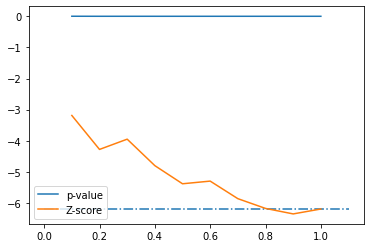

In [37]:
plt.plot(xas, p_vals, label='p-value');
plt.plot(xas, z_stats, label='Z-score');
# plt.plot(xas, Tau_corrs, label='Tau');
plt.hlines(z_stats[-1], xmin=0, xmax=1.1, linestyles='-.')
plt.legend();

### Census Income

In [38]:
df = pd.read_csv(f'{data_root}adult.data', header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
train_cols = df.columns[0:-1]
label = df.columns[-1]
df.dropna(inplace=True)
df['target'] = df[label].astype('category')
df['target'] = df['target'].cat.codes
num_cols = [
    'Age', 'fnlwgt', 'EducationNum', 
    'CapitalGain', 'CapitalLoss', 'HoursPerWeek'
]
target_var = 'target'

In [39]:
res = {}
corr_list = []
p_value_list = []
relationship_list = []

for col in num_cols:
    p, z, Tau, trend = mkTest(df, col, target_var, alpha=alpha)

    corr_list.append(Tau)
    p_value_list.append(p)
    relationship_list.append(trend)

res = {'Feature': num_cols, 'Correlation': corr_list, 'p_value': p_value_list, 'Relationship': relationship_list}
pd.DataFrame(res)

,Feature,Correlation,p_value,Relationship
0,Age,-0.001903,9.847903e-01,no trend
1,fnlwgt,-0.010376,3.541357e-03,decreasing
2,EducationNum,0.916667,9.226613e-07,increasing
3,CapitalGain,0.325737,1.433675e-11,increasing
4,CapitalLoss,0.169135,2.443935e-03,increasing
5,HoursPerWeek,0.316861,5.930019e-06,increasing


In [40]:
output_tables[('adult', 'Mann_Kendall')] = res

In [41]:
xas = np.arange(0.1, 1.1, 0.1)
p_vals = []
z_stats = []
Tau_corrs = []
for x in xas:
    p, z, Tau, _ = mkSampleTest(df, 'fnlwgt', target_var, alpha=alpha, sample_size=x, seed=seed)
    p_vals.append(p)
    z_stats.append(z)
    Tau_corrs.append(Tau)


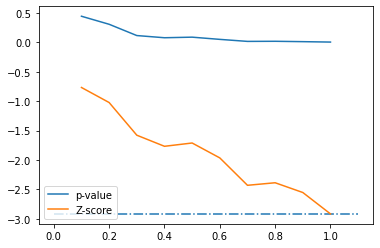

In [42]:
plt.plot(xas, p_vals, label='p-value');
plt.plot(xas, z_stats, label='Z-score');
# plt.plot(xas, Tau_corrs, label='Tau');
plt.hlines(z_stats[-1], xmin=0, xmax=1.1, linestyles='-.')
plt.legend();

In [43]:
xas = np.arange(0.1, 1.1, 0.1)
p_vals = []
z_stats = []
Tau_corrs = []
for x in xas:
    p, z, Tau, _ = mkSampleTest(df, 'CapitalGain', target_var, alpha=alpha, sample_size=x, seed=seed)
    p_vals.append(p)
    z_stats.append(z)
    Tau_corrs.append(Tau)


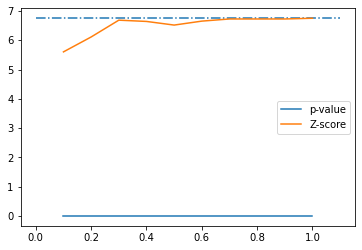

In [44]:
plt.plot(xas, p_vals, label='p-value');
plt.plot(xas, z_stats, label='Z-score');
# plt.plot(xas, Tau_corrs, label='Tau');
plt.hlines(z_stats[-1], xmin=0, xmax=1.1, linestyles='-.')
plt.legend();

In [45]:
xas = np.arange(0.1, 1.1, 0.1)
p_vals = []
z_stats = []
Tau_corrs = []
for x in xas:
    p, z, Tau, _ = mkSampleTest(df, 'CapitalLoss', target_var, alpha=alpha, sample_size=x, seed=seed)
    p_vals.append(p)
    z_stats.append(z)
    Tau_corrs.append(Tau)


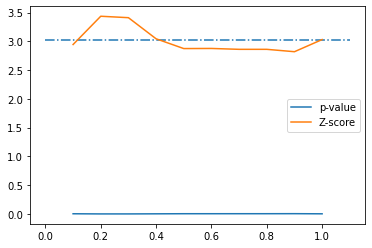

In [46]:
plt.plot(xas, p_vals, label='p-value');
plt.plot(xas, z_stats, label='Z-score');
# plt.plot(xas, Tau_corrs, label='Tau');
plt.hlines(z_stats[-1], xmin=0, xmax=1.1, linestyles='-.')
plt.legend();

In [47]:
xas = np.arange(0.1, 1.1, 0.1)
p_vals = []
z_stats = []
Tau_corrs = []
for x in xas:
    p, z, Tau, _ = mkSampleTest(df, 'HoursPerWeek', target_var, alpha=alpha, sample_size=x, seed=seed)
    p_vals.append(p)
    z_stats.append(z)
    Tau_corrs.append(Tau)


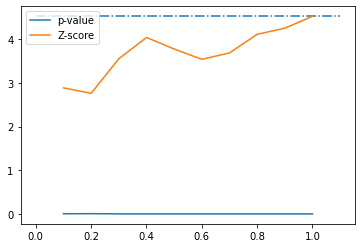

In [48]:
plt.plot(xas, p_vals, label='p-value');
plt.plot(xas, z_stats, label='Z-score');
# plt.plot(xas, Tau_corrs, label='Tau');
plt.hlines(z_stats[-1], xmin=0, xmax=1.1, linestyles='-.')
plt.legend();

### Edmonton House Price

In [49]:
df = pd.read_csv(f'{data_root}housing_train.csv')
df.dropna(inplace=True)
num_cols = ['Latitude', 'Longitude', 'Actual Year Built', 'Lot Size']
target_var = 'Assessed_value_log'

In [50]:
res = {}
corr_list = []
p_value_list = []
relationship_list = []

for i, col in enumerate(num_cols):
    if i < 3:
        p, z, Tau, trend = mkTest(df, col, target_var, alpha=alpha)
    else:
        p, z, Tau, trend = mkSampleTest(df, col, target_var, alpha=alpha, sample_size=0.15, seed=seed)

    corr_list.append(Tau)
    p_value_list.append(p)
    relationship_list.append(trend)

res = {'Feature': num_cols, 'Correlation': corr_list, 'p_value': p_value_list, 'Relationship': relationship_list}
pd.DataFrame(res)

,Feature,Correlation,p_value,Relationship
0,Latitude,-0.140944,1.508615e-11,decreasing
1,Longitude,-0.164236,0.000000e+00,decreasing
2,Actual Year Built,-0.073389,2.355079e-01,no trend
3,Lot Size,0.403766,0.000000e+00,increasing


In [51]:
output_tables[('housing', 'Mann_Kendall')] = res

In [52]:
xas = np.arange(0.1, 1.1, 0.1)
p_vals = []
z_stats = []
Tau_corrs = []
for x in xas:
    p, z, Tau, _ = mkSampleTest(df, 'Latitude', target_var, alpha=alpha, sample_size=x, seed=seed)
    p_vals.append(p)
    z_stats.append(z)
    Tau_corrs.append(Tau)


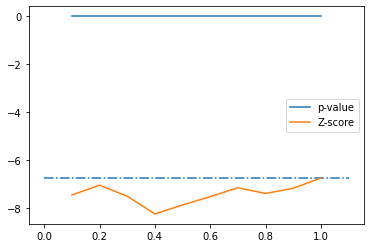

In [53]:
plt.plot(xas, p_vals, label='p-value');
plt.plot(xas, z_stats, label='Z-score');
# plt.plot(xas, Tau_corrs, label='Tau');
plt.hlines(z_stats[-1], xmin=0, xmax=1.1, linestyles='-.')
plt.legend();

In [54]:
xas = np.arange(0.1, 1.1, 0.1)
p_vals = []
z_stats = []
Tau_corrs = []
for x in xas:
    p, z, Tau, _ = mkSampleTest(df, 'Longitude', target_var, alpha=alpha, sample_size=x, seed=seed)
    p_vals.append(p)
    z_stats.append(z)
    Tau_corrs.append(Tau)


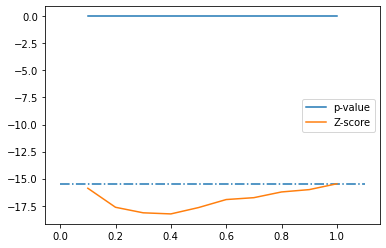

In [55]:
plt.plot(xas, p_vals, label='p-value');
plt.plot(xas, z_stats, label='Z-score');
# plt.plot(xas, Tau_corrs, label='Tau');
plt.hlines(z_stats[-1], xmin=0, xmax=1.1, linestyles='-.')
plt.legend();

In [56]:
xas = np.arange(0.1, 1.1, 0.1)
p_vals = []
z_stats = []
Tau_corrs = []
for x in xas:
    p, z, Tau, _ = mkSampleTest(df, 'Actual Year Built', target_var, alpha=alpha, sample_size=x, seed=seed)
    p_vals.append(p)
    z_stats.append(z)
    Tau_corrs.append(Tau)


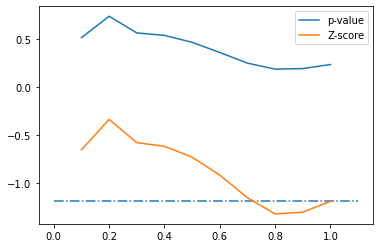

In [57]:
plt.plot(xas, p_vals, label='p-value');
plt.plot(xas, z_stats, label='Z-score');
# plt.plot(xas, Tau_corrs, label='Tau');
plt.hlines(z_stats[-1], xmin=0, xmax=1.1, linestyles='-.')
plt.legend();

### Save results

In [58]:
d = {'Dataset': [], 'Method': [], 'Feature': [], 'Correlation': [], 'p_value': [], 'Relationship': []}
for key, val in output_tables.items():
    tmp = list(key)
    tmp_n = len(val['Feature'])

    d['Dataset'].extend([tmp[0]] * tmp_n)
    d['Method'].extend([tmp[1]] * tmp_n)
    d['Feature'].extend(val['Feature'])
    d['Correlation'].extend(val['Correlation'])
    d['p_value'].extend(val['p_value'])
    d['Relationship'].extend(val['Relationship'])

output_df = pd.DataFrame(d)
output_df

,Dataset,Method,Feature,Correlation,p_value,Relationship
0,heart,Spearman_rank,age,0.384,0.0131,p_value > 0.05 or abs(corr) < 0.5
1,heart,Spearman_rank,trestbps,0.188,0.191,p_value > 0.05 or abs(corr) < 0.5
2,heart,Spearman_rank,chol,0.143,0.166,p_value > 0.05 or abs(corr) < 0.5
3,heart,Spearman_rank,thalach,-0.588,9.01e-10,Decreasing
4,heart,Spearman_rank,oldpeak,0.635,1.08e-05,Increasing
5,heart,Mann_Kendall,age,0.297561,0.005985,increasing
6,heart,Mann_Kendall,trestbps,0.14449,0.130556,no trend
7,heart,Mann_Kendall,chol,0.071541,0.144784,no trend
8,heart,Mann_Kendall,thalach,-0.422222,0.0,decreasing
9,heart,Mann_Kendall,oldpeak,0.457692,0.000027,increasing


In [59]:
output_df.to_csv('explore_monotonicity.csv', index=False)